# CNN ARCHIECTURE(VGG 16)

## Clean Pipeline

In [1]:
import torch
import torch.nn as nn
from torchvision.models import vgg16
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import pickle

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [2]:
def preprocess(image_path):
    """Load and preprocess an image for VGG"""
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(image_path).convert('RGB')
    return transform(img).unsqueeze(0)

## LOAD MODEL

In [3]:
# Load pretrained VGG-16
model = vgg16(weights='IMAGENET1K_V1')

In [5]:
# Dictionary to store activations
activations = {}

def hook_fn(module,input,output):
    activations[module] = output
# Register hooks for all convolutional layers
hook_handles = []
for name,layer in model.named_modules():
    if isinstance(layer,nn.Conv2d):
        handle = layer.register_forward_hook(hook_fn)
        hook_handles.append(handle)


## Deconvolution Function

In [6]:
def deconvolution(activation,conv_layer):
    deconv = nn.ConvTranspose2d(
        in_channels=conv_layer.out_channels,
        out_channels=conv_layer.in_channels,
        kernel_size=conv_layer.kernel_size,
        stride=conv_layer.stride,
        padding=conv_layer.padding,
        bias=False
    )
    deconv.weight.data = conv_layer.weight.data
    return deconv(activation)

## Work on Model

In [7]:
path_1 = "dog-poster.png"
path_2 = "images.jpeg"

C:\Users\emryz\anaconda3\envs\torch\lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


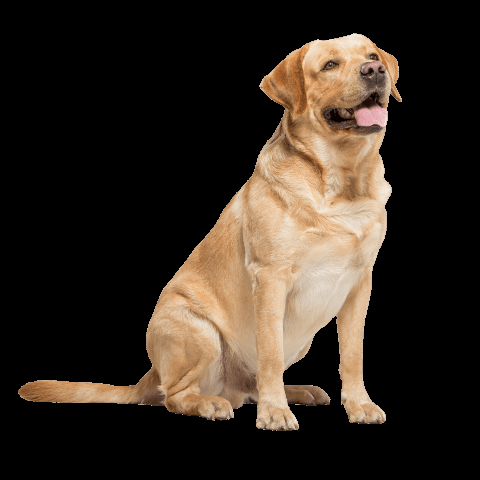

In [8]:
Image.open(path_1).convert("RGB")

In [9]:
## preprocess Image
img = preprocess(path_1)
_ = model(img)

In [10]:
torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)

tensor([[[0.4850]],

        [[0.4560]],

        [[0.4060]]])

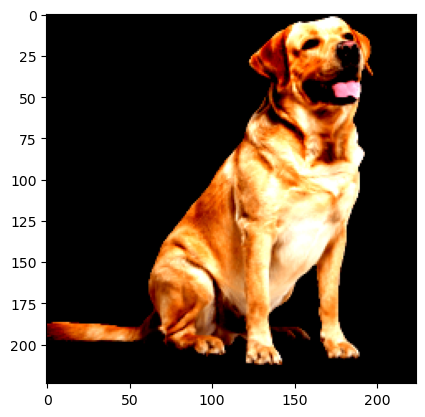

In [11]:
## Display Image tensor
def display_image_tensor(img):
    imgg = img.squeeze(0).detach().cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    imgg = imgg * (std + mean) # Attempt To denormalize
    imgg = torch.clamp(imgg, 0, 1) 
    plt.imshow(imgg.permute(1, 2, 0))
display_image_tensor(img)

In [12]:
import json
## Load JSON for label
path_to_json = "imagenet_class_index.json"
with open(path_to_json) as f:
    labels = json.load(f)

In [13]:
## Make Prediction on the data
logits = model(img) 
_,pred = torch.max(logits,1)
labels[str(pred.item())][1]

'Labrador_retriever'

In [19]:
## Indices of Convolution Layers in VGG 16 features layer
layer_indexes = [i for i,layer in enumerate(model.features) if isinstance(layer,nn.Conv2d)]
layer_indexes

[0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]

In [20]:
## To get the convolution layer at a particular index
layer = model.features[layer_indexes[1]]

In [21]:
## The FEATURE maps generated after going through convolution layer
activation = activations[layer]

In [22]:
## The Shape of the generated FEATURE map
activation.shape

torch.Size([1, 64, 224, 224])

In [23]:
## The Best activated/feature map, based on the criteria of the most fired activation map
mean_feature_maps = torch.mean(activation,dim=(2,3))
top_feature_map = torch.argmax(mean_feature_maps).item()

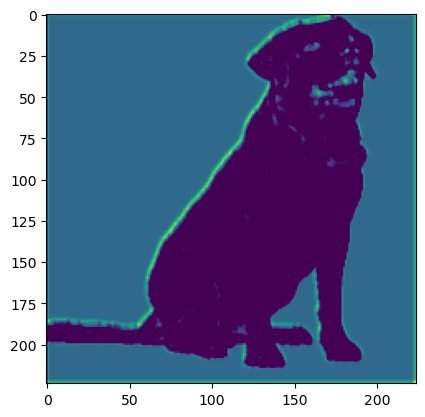

In [24]:
## Show the activation
plt.imshow(activation[:,top_feature_map:top_feature_map+1,:,:].squeeze(0).permute(1,2,0).detach().numpy())

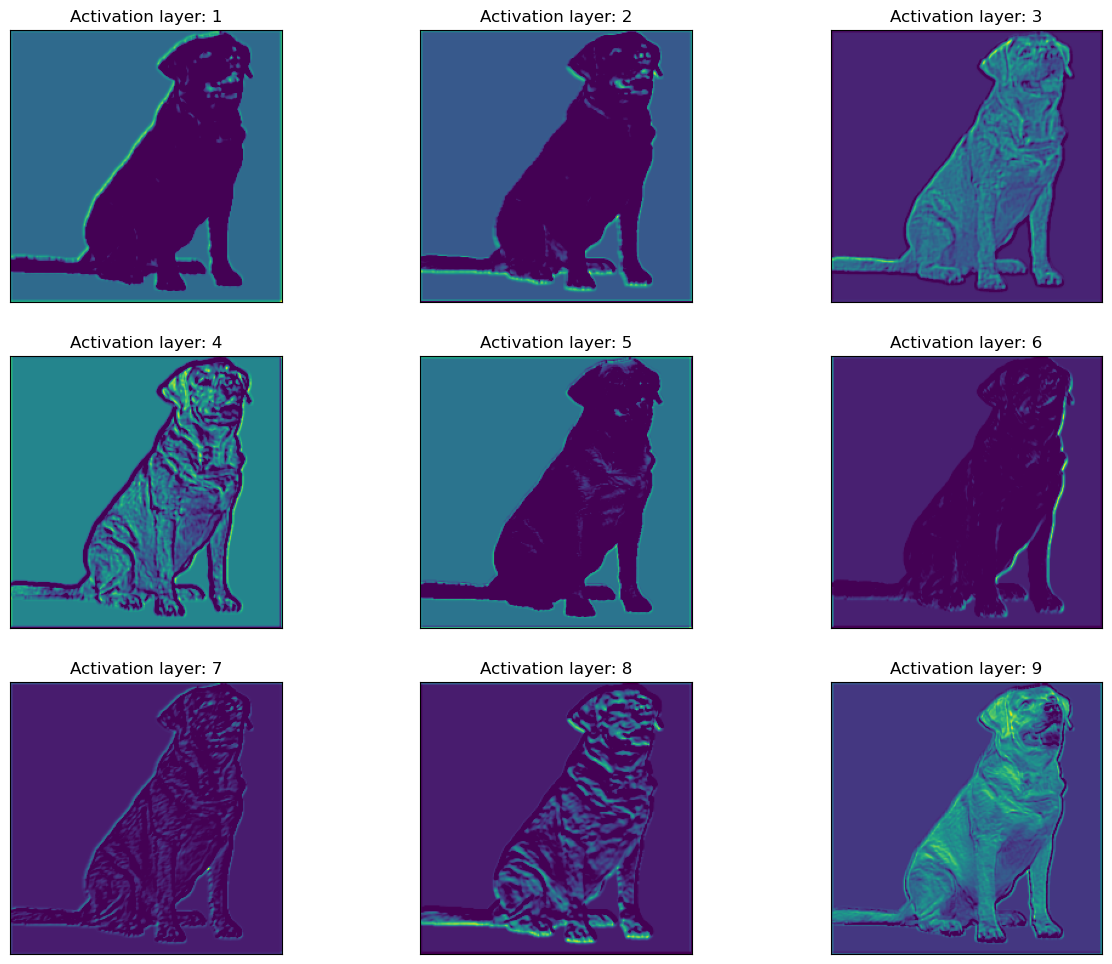

In [25]:
## The Top 9 activation map
mean_feature_maps  = torch.mean(activation,dim=(2,3))
top_values_act, top_indices_act = torch.topk(mean_feature_maps, k=9)

plt.figure(figsize=(15,12))
for idx,top in enumerate(top_indices_act[0].numpy()):
    plt.subplot(3,3,idx+1)
    plt.title(f"Activation layer: {idx+1}")
    plt.imshow(activation[:,top:top+1,:,:].squeeze(0).permute(1,2,0).detach().numpy())
    plt. xticks([])
    plt. yticks([])
plt.show()

In [26]:
# The Top approximate input
approximate_input = deconvolution(activation,layer)
# Most Active approx input
most_active_approx_input = torch.argmax(torch.mean(approximate_input,dim=(2,3))).item()

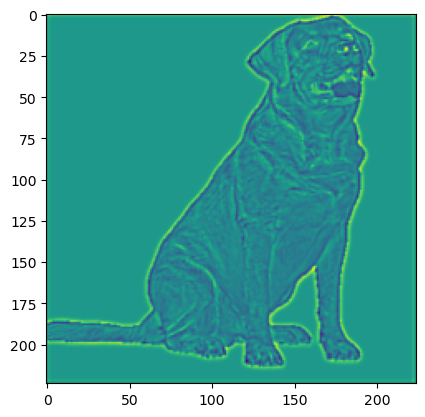

In [27]:
plt.imshow(approximate_input.squeeze(0).detach().permute(1,2,0)[:,:,most_active_approx_input])

In [28]:
# The Top approximate input, I also want to show case the top 9 active inputs
top_values, top_indices = torch.topk(torch.mean(approximate_input,dim=(2,3)), k=9)

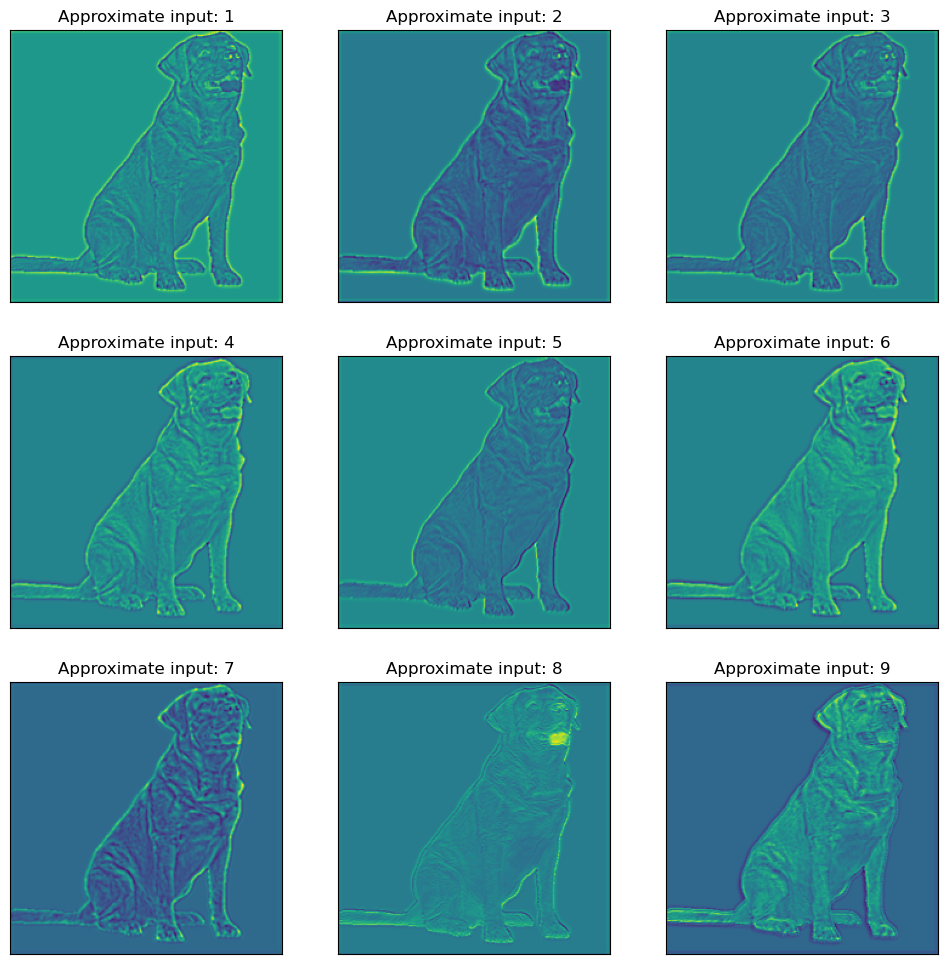

In [29]:
plt.figure(figsize=(12,12))
for idx,top in enumerate(top_indices[0].numpy()):
    plt.subplot(3,3,idx+1)
    plt.title(f"Approximate input: {idx+1}")
    plt.imshow(approximate_input.squeeze(0).detach().permute(1,2,0)[:,:,top])
    plt. xticks([])
    plt. yticks([])
plt.show()

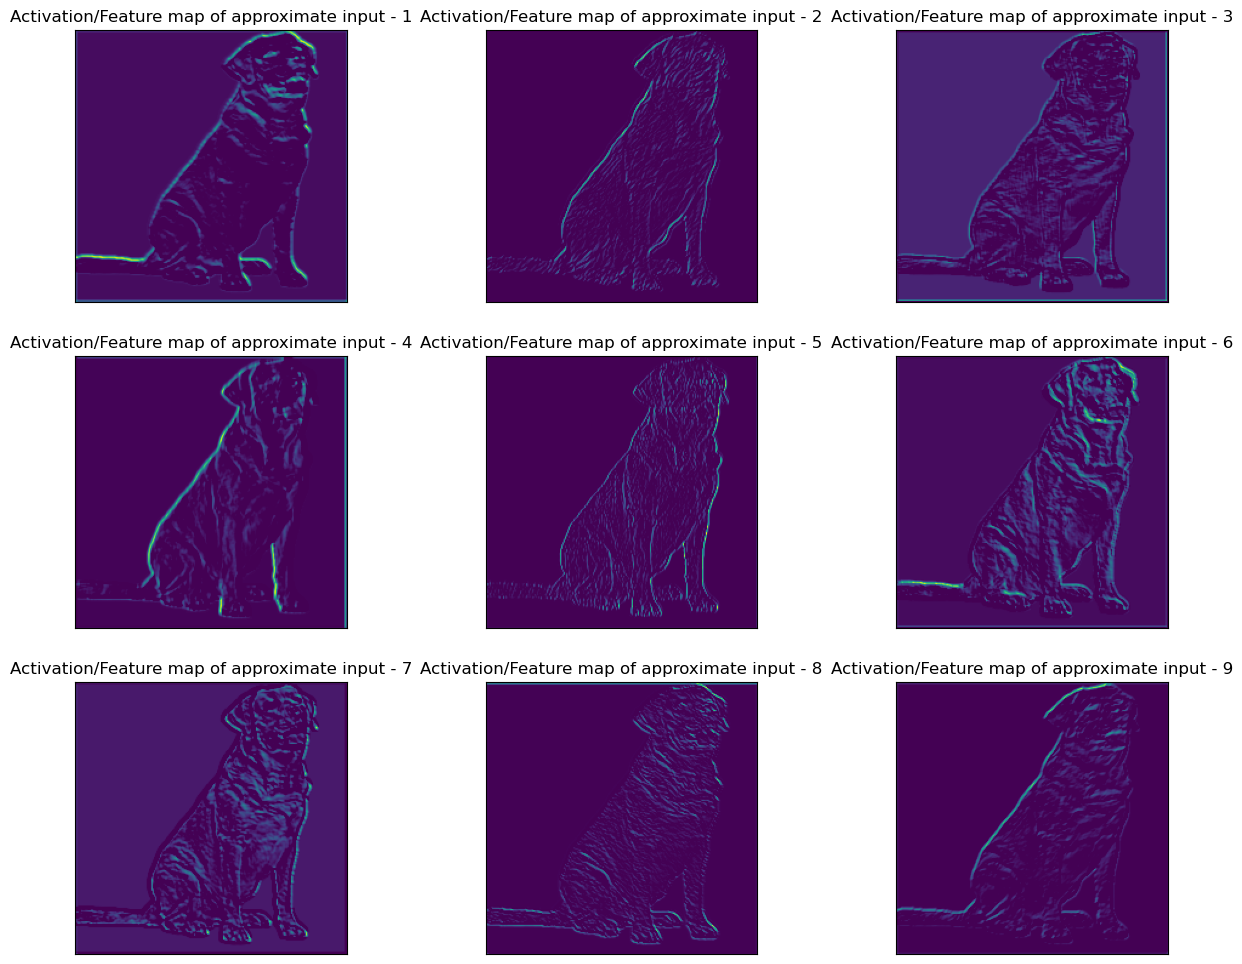

In [24]:
## The Corresponding feature maps of the 9 appximate input image
plt.figure(figsize=(15,12))
for idx,top in enumerate(top_indices[0].numpy()):
    plt.subplot(3,3,idx+1)
    plt.title(f"Activation/Feature map of approximate input - {idx+1}")
    plt.imshow(activation[:,top:top+1,:,:].squeeze(0).permute(1,2,0).detach().numpy())
    plt. xticks([])
    plt. yticks([])
plt.show()

## Seralization of activation to dictionary

In [31]:
first_module = list(activations.keys())[0]

In [54]:
first_data = {
    first_module: activations[first_module]
}

In [110]:
import os
def pytorch_to_json(model_dict,output_dir="model_data"):
    os.makedirs(output_dir,exist_ok=True)
    metadata = {"model_info": {
        "total_layers": 10,
        "input_shape": [3, 224, 224]
    },"layers":[]}

    for i,(module, tensor) in enumerate(model_dict.items()):
        layer_name = f"conv{i+1}"
        layer_file = f"{output_dir}/{layer_name}.json"

        with open(layer_file,"w") as f:
            json.dump({
                "module": {
                    "name":str(module),
                    "in_channels": module.in_channels,
                    "out_channels": module.out_channels,
                    "kernel_size": module.kernel_size,
                    "stride": module.stride,
                    "padding": module.padding,
                    "weights": module.weight.detach().cpu().numpy().tolist(),
                },
                "output": tensor.detach().numpy().tolist()
            },f)
        
        metadata["layers"].append({
            "name":layer_name,
            "file": layer_file
        })

    with open(f"{output_dir}/metadata.json","w") as f:
        json.dump(metadata,f,indent=2)
        

In [111]:
## Save model
pytorch_to_json(activations)


In [36]:
import os
import pickle

def pytorch_to_pickle(model_dict,output_dir="modeldatapickle"):
    os.makedirs(output_dir,exist_ok=True)
    metadata = {"model_info": {
        "total_layers": 10,
        "input_shape": [3, 224, 224]
    },"layers":[]}

    for i,(module, tensor) in enumerate(model_dict.items()):
        layer_name = f"conv{i+1}"
        layer_file = f"{output_dir}/{layer_name}.pkl"

        with open(layer_file,"wb") as f:
            pickle.dump({
                "module": {
                    "name":str(module),
                    "in_channels": module.in_channels,
                    "out_channels": module.out_channels,
                    "kernel_size": module.kernel_size,
                    "stride": module.stride,
                    "padding": module.padding,
                    "weights": module.weight.detach().cpu().numpy().tolist(),
                },
                "output": tensor.detach().numpy().tolist()
            },f)
        
        metadata["layers"].append({
            "name":layer_name,
            "file": layer_file
        })

    with open(f"{output_dir}/metadata.json","w") as f:
        json.dump(metadata,f,indent=2)

In [37]:
## Save to pickle
pytorch_to_pickle(activations)

## Grad CAM

In [805]:
import cv2

In [806]:
image_to_heatmaps = nn.Sequential(*list(model.features[:-4]))

In [807]:
def compute_heatmap(model,img):
    model.eval()
    logits = model(img)
    pred = torch.max(logits,-1)[-1]
    activations = image_to_heatmaps(img)
    # compute gradients with respect to the model's most confident prediction
    logits[0, pred].backward(retain_graph=True)
    # average gradients of the featuremap 
    pool_grads = model.features[-3].weight.data.mean((0,2,3))
    for i in range(activations.shape[1]):
        activations[:,i,:,:] *= pool_grads[i]
    # calculate mean of weighted activations
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, pred

In [808]:
def upsampleHeatmap(mapp,image):
    image = image.squeeze(0).permute(1,2,0).cpu().numpy()
    # maximum and minimum value from heatmap
    m, M = mapp.min(), mapp.max()
    # normalize the heatmap
    mapp = 255 * ((mapp-m)/(M-m))
    mapp = np.uint8(mapp)
    # resize the heatmap to the same as the input
    mapp = cv2.resize(mapp, (224, 224))
    mapp = cv2.applyColorMap(255-mapp, cv2.COLORMAP_JET)
    mapp = np.uint8(mapp)
    # change this to balance between heatmap and image
    mapp = np.uint8(mapp*0.7 + image*0.3)
    return mapp

In [809]:
def display_images(upsampled_map, image):
    image = image.squeeze(0).permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(upsampled_map)
    axes[0].set_title("Heatmap")
    axes[0].axis('off')
    axes[1].imshow(image)
    axes[1].set_title("Original Image")
    axes[1].axis('off')
    plt.show()

In [810]:
heatmap,pred = compute_heatmap(model,img)

In [811]:
upsampled_map = upsampleHeatmap(heatmap,img)

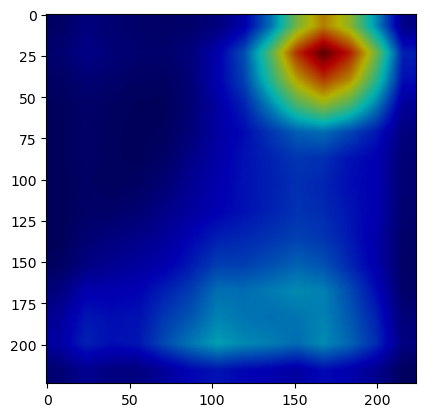

In [812]:
plt.imshow(upsampled_map)